**Nome:** Riccardo <br>
**Cognome:** Confalonieri<br>
**Numero matricola:** 830404<br>
**E-mail:** r.confalonieri5@campus.unimib.it<br>
**A.A.** 2021-2022<br>

# **Digital Signal and Image Management - Assignment 2**<br/>
**Master's Degree in Data Science (A.Y. 2021/2022)**<br/>
**University of Milano - Bicocca**<br/>

Simone Bianco, Marco Buzzelli

## Descrizione
<p align = 'justify'>
Experiment with the compression of a color image by blurring the channels of the YCbCr representation, following the guidelines shown during the laboratory.

Rules:
1. Use a custom image (different from the ones provided).
2. Show the effect of blurring the luma channel, and the effect of blurring the chroma channels.
3. Experiment with, and show, the impact of blurring with different intensities.

<p/>

## Import delle librerie

In [3]:
import numpy as np
from matplotlib import pyplot as plt

# Image management. In alternativa potevo usare pillow/PyTorch/openCV
from skimage import io as skio # Input/output
from skimage import transform # Geometric transformations (e.g. resize)
from skimage import filters # Local processing
from skimage import color # Change of color space
# for save image with 100% quality, skimage drop image quality without control!
from PIL import Image

# for get image size
import io

# Set visualization size for figures
plt.rcParams['figure.figsize'] = [15,15] # width, height

# Mount GDrive
from google.colab import drive

import math
# for saving deep copy of array
import copy

In [ ]:
def compare_image(lst_img, lst_title, ncols = None, nrows = None,  
                  colormap = 'viridis', height = 15, width = 15):
  """
    Funzione che visualizza un insieme di immagini con il rispettivo titolo.
    Di default la funzione visualizza le immagini su due colonne ed N righe, ma
    è altresì possibile modificare questi valori.
    E' inoltre possibile modificare la dimensione dell'immagine e/o la colormap
  """

  # se il numero di righe e o colonne non è stato definito lo calcolo, settando ncols = 2 di default
  if (nrows is None) or (ncols is None):
    # setto il numero di colonne
    ncols = 2
    # calcolo il numero di righe
    nrows = math.ceil(len(lst_img)/2.)

  # setto la dimensione delle immagini
  plt.figure(figsize=(height,width))

  for index in range(0, len(lst_img)):
    # visualizzo le immagine
    plt.subplot(nrows, ncols, index+1)
    plt.imshow(lst_img[index], cmap = colormap)
    plt.title(lst_title[index])

  plt.show()

In [ ]:
def min_max_range_image(img, min_range = 0., max_range = 1.):
  """
    Funzione che verifica che tutti i valori presenti nell'immagine siano compresi
    nel range settato, di default [0,1]. Questo per evitare possibili warnings 
    e/o errori nella visualizzazione dell'immagine
  """

  # controllo se contiene valori maggiori di 1
  if img.max() > max_range:
    img[img > max_range] = int(max_range)
  # controllo se contiene valori minori di 0
  if img.min() < min_range:
    img[img < min_range] = int(min_range)

  return img

In [ ]:
def float_image_to_int(img):
  """
    Funzione che dato in input un immagine con valori float compresi nel range
    [0,1] la converte in un immagine con valori interi nel range [0, 255]
  """

  # se i valori dell'immagine sono ti tipo float li converto
  if img.dtype == np.float:
    return (img * 255).astype(np.uint8)
  else:
    return img

In [ ]:
def get_img_mbytes(image):
  """
    Funzione che data un immagine (array numpy) ne calcola la dimensione in bytes
    senza effettuare un reale salvataggio su disco.
  """

  # se necessario converto i valori dell'immagine ad intero [0,255]
  # è necessario convertire ad intero perchè utilizzo la libreria PIL che non riesce
  # a gestire correttamente i valori float nell'intervallo [0,1]
  image = float_image_to_int(image)

  # Codifico nella memoria e prendo la dimensione, senza salvare su disco
  buffer = io.BytesIO()
  Image.fromarray(image).save(buffer, format="JPEG", quality=100)
  s = buffer.getbuffer().nbytes

  # elimino buffer dalla memoria, occupa tanto spazio e non serve a nulla mantenerlo
  del buffer

  return s/(1024*1024)

## Loading image and analysis

In [4]:
# Link Google Drive account
drive.mount('/content/gdrive')
path = '/content/gdrive/MyDrive/Colab Notebooks/DigitalSignal/Assignment/Assignment2/'

Mounted at /content/gdrive


In [ ]:
# Carico l'immagine dal drive
img = skio.imread(path + 'IMG_2796.JPG')

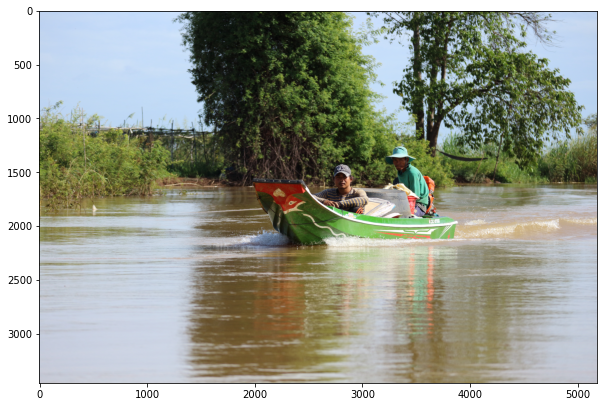

In [ ]:
# visualizzo l'immagine
plt.rcParams['figure.figsize'] = [10,10]
plt.imshow(img)
plt.show()

### Image analysis
Provo a visualizzare alcune informazioni essenziali sull'immagine. <br>
In prima istanza mi concentro sulla risoluzione dell'immagine e sul numero di canali caricati, essendo un'immagine a colori mi aspetto che siano stati caricati i canonici 3 canali (RGB). In questo caso l'immagine caricata è di tipo JPG, se fosse stata di tipo PNG in automatico sarebbe stato caricato anche un quarto canale, l'alphachannel, che ne codifica il livello di opacità.

In [ ]:
# visualizzo alcune caratteristiche dell'immagine importata
print("Tipo della variabile:", type(img))
print("Risoluzione spaziale:", img.shape[:2])
# il numero di canali dovrebbero essere 3 (red, green, blue)
print("Numero di canali:", img.shape[2])

Tipo della variabile: <class 'numpy.ndarray'>
Risoluzione spaziale: (3456, 5184)
Numero di canali: 3


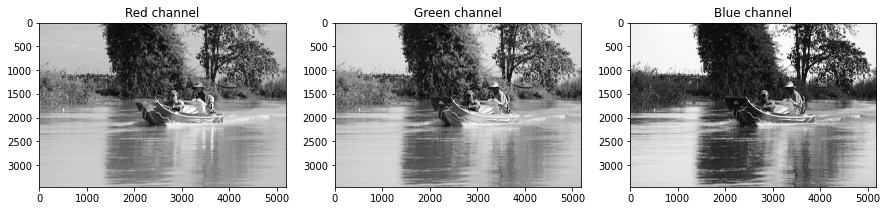

In [ ]:
# visualizzo i singoli canali dell'immagine
compare_image([img[:,:,0], img[:,:,1], img[:,:,2]],
              ['Red channel', 'Green channel', 'Blue channel'], 3, 1, 'gray')

## YCBCR space color

<p align='justify'>
Converto l'immagine nello spazio colore richiesto per l'esercizio, provo poi a modificarla applicando un filtro gaussiano alle diverse componenti dell'immagine (Y, Cb e Cr) considerandone una o più per volta.
Confronto poi i risultati ottenuti dalle singole trasformazioni in termini di qualità e compressione (spazio di archiviazione) dell'immagine. <br>
Il risultato atteso è che modificando Cb e Cr l'immagine risulti più compressa su disco senza però perdere in qualità, mentre modificando la Y l'immagine risulti si più compressa ma molto meno bella da vedere.
<p/>

In particolare la conversione in ycbcr è ottenuta dalla codifica RGB a 8 bit con la seguente formula:

$$Y' = 16  + 1/256 * (65.738*R +  129.057*G +  25.064*B)$$
$$Cb = 128 + 1/256 * (-37.945*R -   74.494*G + 112.439*B)$$
$$Cr = 128 + 1/256 * (112.439*R -   94.154*G -  18.285*B)$$

con $Y \in [16, 17, ..., 235]$ e $Cb,Cr \in [16, 17, ..., 240]$

Fonte: https://it.wikipedia.org/wiki/YCbCr

In [ ]:
# applico la trasformazione da rgb allo spazio ycbcr
img_ycbcr = color.rgb2ycbcr(img)

# salvo le colonne originali prima di modificarle in modo da poterle ripristinare
original_cb = copy.deepcopy(img_ycbcr[:,:,1])
original_cr = copy.deepcopy(img_ycbcr[:,:,2])
original_y = copy.deepcopy(img_ycbcr[:,:,0])

In [ ]:
# verifico i valori max e min di Y, Cb e Cr secondo la definizione appena data
print('Y compresa in: [' + str(img_ycbcr[:,:,0].min()) + 
      ', ' + str(img_ycbcr[:,:,0].max()) + ']')

print('Cb compresa in: [' + str(img_ycbcr[:,:,1].min()) + 
      ', ' + str(img_ycbcr[:,:,1].max()) + ']')

print('Cr compresa in: [' + str(img_ycbcr[:,:,2].min()) + 
      ', ' + str(img_ycbcr[:,:,2].max()) + ']')

Y compresa in: [16.0, 235.0]
Cb compresa in: [63.03520392156862, 160.69382352941176]
Cr compresa in: [53.48370980392157, 218.48908235294118]


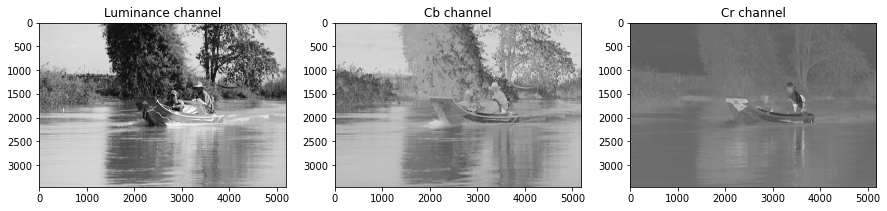

In [ ]:
# visualizzo i singoli canali dell'immagine nello spazio colore ycbcr
compare_image([img_ycbcr[:,:,0], img_ycbcr[:,:,1], img_ycbcr[:,:,2]],
              ['Luminance channel', 'Cb channel', 'Cr channel'], 3, 1, 'gray')

Dall'analisi dei singoli canali dello spazio colore YCBCR si nota come il canale Cr riguardi solo piccole porzioni delle immagini sulla barca in particolae. Mentre il canale Cb influenza in maniera più o meno tutta l'immagine.

### Filter on Cb
<p align='justify'>
Applico il filtro gaussiano sulla componente Cb dell'immagine con diversi valori di sigma per verificarne l'effetto sia visivo che in termini di spazio. La componente Cb nello specifico lavora nel canale cromatico del blu e giallo, inoltre data la visualizzazione precedente mi aspetto che filtri su questo canale influenzino più punti di questa immagine.
<p/>

In [ ]:
# applico il filtro gaussiano sulla componente cb dell'immagine
cb_5 = filters.gaussian(img_ycbcr[:,:,1], sigma=5)
cb_10 = filters.gaussian(img_ycbcr[:,:,1], sigma=10)
cb_20 = filters.gaussian(img_ycbcr[:,:,1], sigma=20)
cb_100 = filters.gaussian(img_ycbcr[:,:,1], sigma=100)

<p align='justify'>
Per poter visualizzare correttamente le immagini è necessario riconvertire da ycbcr a rgb, nel farlo utilizzo le colonne appena create con i differenti filtri al posto della colonna Cb orinale. <br>
E' inoltre necessario riscalare i valori nel range $[0,1]$ in quanto durante la conversione la libreria skimage introduce dei valori leggermente fuori dal range (solo se si considerano tutte le n cifre decimali). Questo però genera dei warnings e/o errori durante la visualizzazione e il salvataggio del file in quanto sono valori non previsti nelle immagini rgb.
<p/>

In [ ]:
img_ycbcr[:,:,1] = cb_5
# converto in rbg l'immagine con sigma = 5
img_cb_5 = color.ycbcr2rgb(img_ycbcr)

img_ycbcr[:,:,1] = cb_10
# converto in rbg l'immagine con sigma = 10
img_cb_10 = color.ycbcr2rgb(img_ycbcr)

img_ycbcr[:,:,1] = cb_20
# converto in rbg l'immagine con sigma = 20
img_cb_20 = color.ycbcr2rgb(img_ycbcr)

img_ycbcr[:,:,1] = cb_100
# converto in rbg l'immagine con sigma = 100
img_cb_100 = color.ycbcr2rgb(img_ycbcr)


# riscalo i valori perchè in alcuni casi la eccedono il range [0,1] all'n-esima cifra dopo la virgola
img_cb_5 = min_max_range_image(img_cb_5)
img_cb_10 = min_max_range_image(img_cb_10)
img_cb_20 = min_max_range_image(img_cb_20)
img_cb_100 = min_max_range_image(img_cb_100)

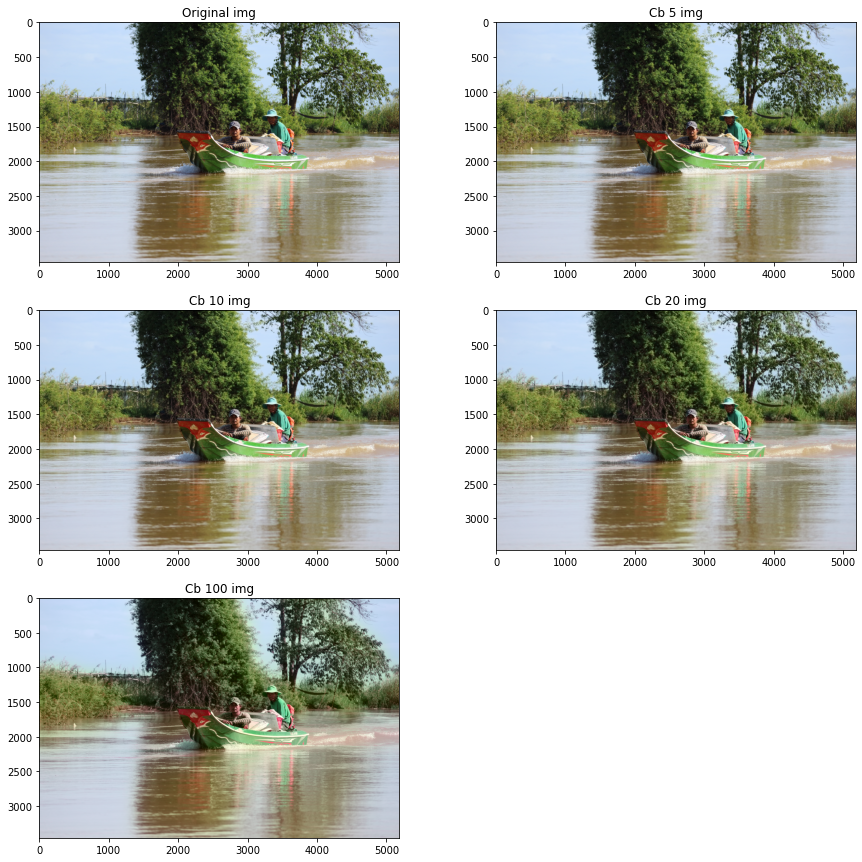

In [ ]:
# visualizzo le immagini ottenute con i filtri
compare_image([img, img_cb_5, img_cb_10, img_cb_20, img_cb_100], 
              ['Original img', 'Cb 5 img', 'Cb 10 img', 'Cb 20 img', 'Cb 100 img'])

#### Results analysis
<p align='justify'>
Dal punto di vista qualitativo l'immagine risulta essere molto bella anche con deviazioni per il filtro gaussiano abbastanza elevate. Ad esempio con $\sigma = 20$ il risultato è <i>molto simile all'originale</i> e non si notano particolari distorsioni se non con <i>zoom specifici</i>, solo con l'ultimo filtro con $\sigma = 100$ si riescono infatti a <i>notare delle distorsioni</i> intorno agli alberi piuttosto che nel colore della scia della barca o nell'acqua in prua che risulta essere più verdognola rispetto all'originale. <br>
Si riporta di seguito un esempio di queste distorsioni per maggiore chiarezza.

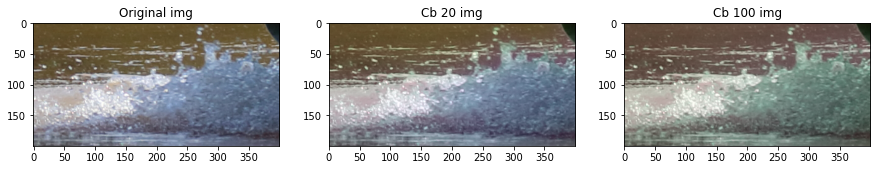

In [ ]:
# visualizzo l'acqua in prua per vedere la differenza tra originale, cb_20, cb_100
compare_image([img[2000:2200, 1800:2200], img_cb_20[2000:2200, 1800:2200],
               img_cb_100[2000:2200, 1800:2200]], 
              ['Original img', 'Cb 20 img', 'Cb 100 img'], 3, 1)

<p align='justify'>
Da questo zoom si nota che anche l'immagine con $\sigma = 20$ introduce delle leggere alterazioni però, come già evidenziato, queste non sono particolarmente visibili se si guarda l'immagine nel complesso. Tuttavia ad alcuni utenti potrebbero dare fastidio quindi per le prove fatte su cb sarebbe meglio non eccedere a $\sigma = 10$ nel filtro gaussiano.
<p/>

In [ ]:
# Salvo l'immagine su disco nel caso si voglia vedere nel complesso
# PIL non supporta nativamente le immagini RGB con valori float, quindi li converto ad intero
Image.fromarray(float_image_to_int(img_cb_20)).save("test_cb_20.jpg", quality=100)

<p align='justify'>
Dall'altra parte a noi interessa in qualche modo ottimizzare anche lo spazio di archiviazione dell'immagine, si riportano di seguito i valori in MB necessari per salvare l'immagine su disco. <br>
<b>NB:</b> Tali valori sono ottenuti senza sfruttare la conversione jpg, lasciando quindi intatta la qualità dell'immagine al $100\%$
<p/>

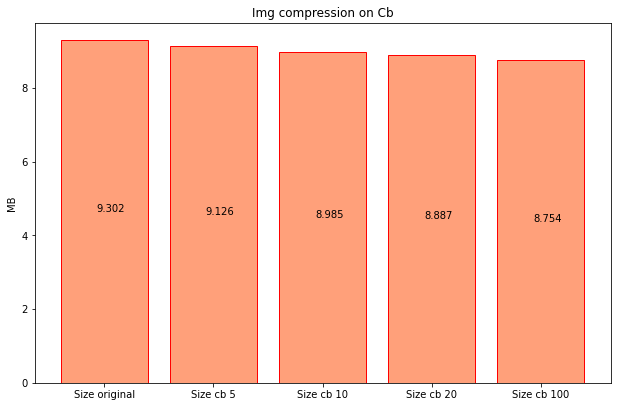

In [ ]:
# estraggo la stima della dimensione su disco delle immagini con e senza filtro
size_img = get_img_mbytes(img)
size_img_cb_5 = get_img_mbytes(img_cb_5)
size_img_cb_10 = get_img_mbytes(img_cb_10)
size_img_cb_20 = get_img_mbytes(img_cb_20)
size_img_cb_100 = get_img_mbytes(img_cb_100)


# plotto i risultati in un grafico a barre
fig = plt.figure()
fig.set_size_inches(8,5)
ax = fig.add_axes([0,0,1,1])
langs = ['Size original', 'Size cb 5', 'Size cb 10', 'Size cb 20', 'Size cb 100']
ax.bar(langs, [size_img, size_img_cb_5, size_img_cb_10, 
               size_img_cb_20, size_img_cb_100], 
       color="lightsalmon",  edgecolor='red')
ax.set_title('Img compression on Cb')
ax.set_ylabel('MB')

# print value in bar
for pos, val in zip(range(0,5), [size_img, size_img_cb_5, size_img_cb_10, 
                            size_img_cb_20, size_img_cb_100]):
  plt.text(pos-.07, val/2, round(val,3))

plt.show()

<p align='justify'>
Dal grafico si nota, come previsto, che più il filtro è "forte" più aumenta la compressione dell'immagine. Sfruttando anche la compressione offerta da jpeg questi valori possono essere ridotti ulteriormente, in questo caso però si è voluto mantenere la stessa qualità dell'immagine per un confronto il più accurato possibile.
<p>

### Filter on Cr
<p align='justify'>
Applico gli stessi passaggi appena effettuati sulla componente Cr, ripristinando Cb al valore di partenza. La componente Cr nello specifico lavora nel canale cromatico del rosso e verde, dato che l'immagine iniziale non presenta molte zone rosse mi aspetto che il valore di sigma in questo caso possa anche aumentare leggermente senza alterazioni significative.
<p/>

In [ ]:
# ripristino la colonna cb originale
img_ycbcr[:,:,1] = original_cb

In [ ]:
# applico il filtro gaussiano sulla componente cr dell'immagine
cr_5 = filters.gaussian(img_ycbcr[:,:,2], sigma=5)
cr_10 = filters.gaussian(img_ycbcr[:,:,2], sigma=10)
cr_20 = filters.gaussian(img_ycbcr[:,:,2], sigma=20)
cr_100 = filters.gaussian(img_ycbcr[:,:,2], sigma=100)

<p align='justify'>
Per poter visualizzare correttamente le immagini è necessario riconvertire da ycbcr a rgb, nel farlo utilizzo le colonne appena create con i differenti filtri al posto della colonna cb orinale. <br>
E' inoltre necessario riscalare i valori nel range $[0,1]$ in quanto durante la conversione la libreria skimage introduce dei valori leggermente fuori dal range (solo se si considerano tutte le n cifre decimali). Questo però genera dei warnings e/o errori durante la visualizzazione e il salvataggio del file in quanto sono valori non previsti nelle immagini rgb.
<p/>

In [ ]:
img_ycbcr[:,:,2] = cr_5
# converto in rbg l'immagine con sigma = 5
img_cr_5 = color.ycbcr2rgb(img_ycbcr)

img_ycbcr[:,:,2] = cr_10
# converto in rbg l'immagine con sigma = 10
img_cr_10 = color.ycbcr2rgb(img_ycbcr)

img_ycbcr[:,:,2] = cr_20
# converto in rbg l'immagine con sigma = 20
img_cr_20 = color.ycbcr2rgb(img_ycbcr)

img_ycbcr[:,:,2] = cr_100
# converto in rbg l'immagine con sigma = 100
img_cr_100 = color.ycbcr2rgb(img_ycbcr)


# riscalo i valori perchè in alcuni casi la eccedono il range [0,1] all'n-esima cifra dopo la virgola
img_cr_5 = min_max_range_image(img_cr_5)
img_cr_10 = min_max_range_image(img_cr_10)
img_cr_20 = min_max_range_image(img_cr_20)
img_cr_100 = min_max_range_image(img_cr_100)

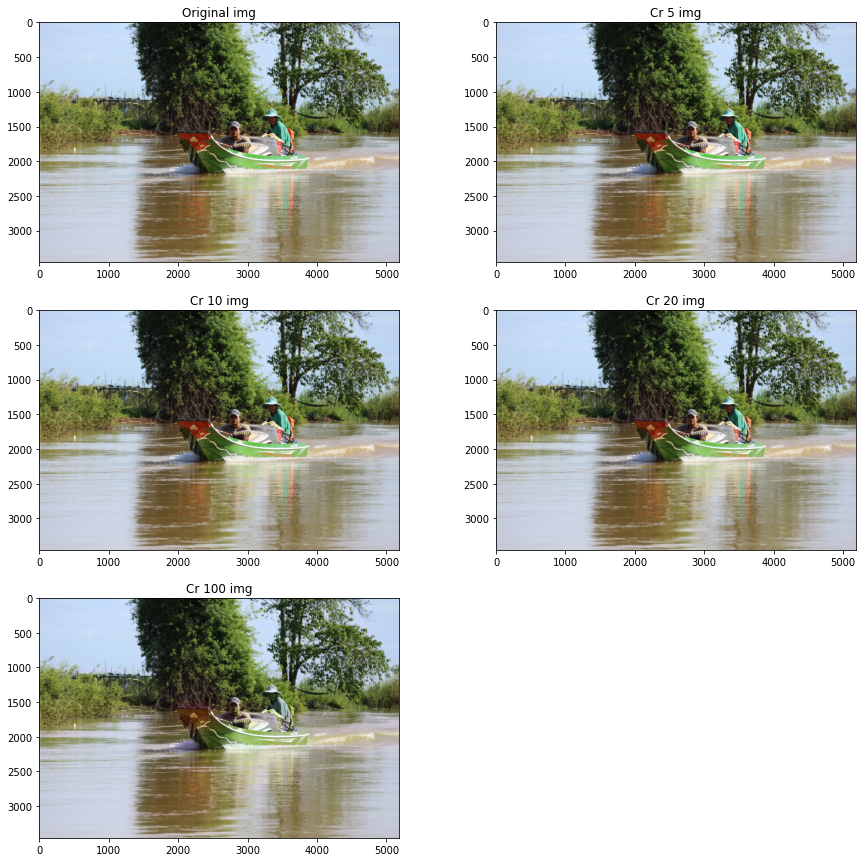

In [ ]:
compare_image([img, img_cr_5, img_cr_10, img_cr_20, img_cr_100],
              ['Original img', 'Cr 5 img', 'Cr 10 img', 'Cr 20 img', 'Cr 100 img'])

#### Results analysis
<p align='justify'>
Anche in questo caso l'immagine risulta essere molto bella e con poche alterazioni anche con sigma elevati, inoltre come ci si aspettava essendo il rosso poco predominante nell'immagine scelta anche con $\sigma = 20$ non si notano particolari alterazioni nel complesso. Soltanto col $\sigma = 100$ si riescono infatti a <i>notare delle distorsioni</i> soprattutto nella punta della nave e negli oggetti intorno alla persona seduta dietro, i punti rossi dell'immagine evidenziati all'inizio nell'analisi sulla singola componente Cr. Quindi a differenza del caso precedente si può utilizzare un sigma leggermente più elevato per il canale Cr.<br>
Si riporta di seguito un esempio di queste distorsioni per maggiore chiarezza.

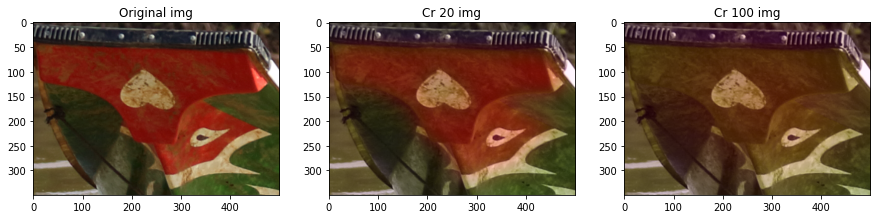

In [ ]:
# visualizzo la prua per vedere la differenza tra originale, cr_20, cr_100
compare_image([img[1550:1900, 2000:2500], img_cr_20[1550:1900, 2000:2500],
               img_cr_100[1550:1900, 2000:2500]], 
              ['Original img', 'Cr 20 img', 'Cr 100 img'], 3, 1)

<p align='justify'>
Da questo zoom si nota che anche l'immagine con $\sigma = 20$ introduce delle leggere alterazioni però, come già evidenziato, queste non sono particolarmente visibili se si guarda l'immagine nel complesso. Tuttavia ad alcuni utenti potrebbero dare fastidio quindi per le prove fatte su Cr sarebbe meglio non eccedere a $\sigma = 10$ nel filtro gaussiano.
<p/>

In [ ]:
# Salvo l'immagine su disco nel caso si voglia vedere nel complesso
# PIL non supporta nativamente le immagini RGB con valori float, quindi li converto ad intero
Image.fromarray(float_image_to_int(img_cr_20)).save("test_cr_20.jpg", quality=100)

<p align='justify'>
Dall'altra parte a noi interessa in qualche modo ottimizzare anche lo spazio di archiviazione dell'immagine, si riportano di seguito i valori in MB necessari per salvare l'immagine su disco. <br>
<b>NB:</b> Tali valori sono ottenuti senza sfruttare la conversione jpg, lasciando quindi intatta la qualità dell'immagine al $100\%$
<p/>

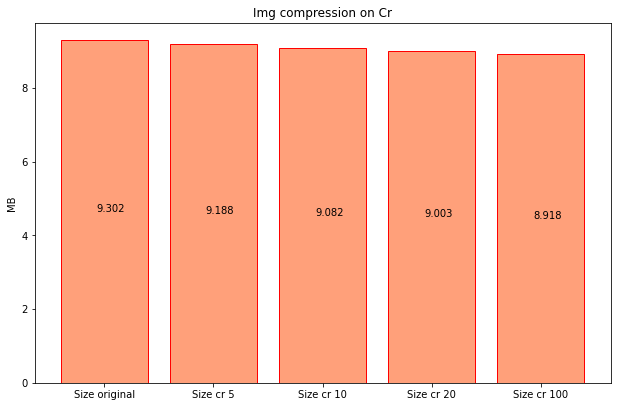

In [ ]:
# estraggo la stima della dimensione su disco delle immagini con e senza filtro

#size_img = get_img_mbytes(img)
size_img_cr_5 = get_img_mbytes(img_cr_5)
size_img_cr_10 = get_img_mbytes(img_cr_10)
size_img_cr_20 = get_img_mbytes(img_cr_20)
size_img_cr_100 = get_img_mbytes(img_cr_100)


# plotto i risultati in un grafico a barre
fig = plt.figure()
fig.set_size_inches(8,5)
ax = fig.add_axes([0,0,1,1])
langs = ['Size original', 'Size cr 5', 'Size cr 10', 'Size cr 20', 'Size cr 100']
ax.bar(langs, [size_img, size_img_cr_5, size_img_cr_10, 
               size_img_cr_20, size_img_cr_100], 
       color="lightsalmon",  edgecolor='red')
ax.set_title('Img compression on Cr')
ax.set_ylabel('MB')

# print value in bar
for pos, val in zip(range(0,5), [size_img, size_img_cr_5, size_img_cr_10, 
                            size_img_cr_20, size_img_cr_100]):
  plt.text(pos-.07, val/2, round(val,3))

plt.show()

<p align='justify'>
Dal grafico si nota, come previsto, che più il filtro è "forte" più aumenta la compressione dell'immagine. Sfruttando anche la compressione offerta da jpeg questi valori possono essere ridotti ulteriormente, in questo caso però si è voluto mantenere la stessa qualità dell'immagine per un confronto il più accurato possibile. <br>
Inoltre si evidenzia il fatto che la compressione su Cr è <i>meno performante</i> rispetto a quella su Cb. Questo è probabilmente dovuto al fatto che, come analizzato nella prima analisi sulle singole componenti, il canale Cr è poco presente nell'immagine.
<p>

### Filter on Cb & Cr
<p align='justify'>
Applico gli stessi passaggi appena effettuati sia sulla componente Cb che su Cr.
<p/>

In [ ]:
# ripristino la colonna cb originale
img_ycbcr[:,:,1] = original_cb
# ripristino la colonna cr originale
img_ycbcr[:,:,2] = original_cr

<p align='justify'>
Per poter visualizzare correttamente le immagini è necessario riconvertire da ycbcr a rgb, nel farlo utilizzo le colonne create precedentemente sia per cb che cr.
<p/>

In [ ]:
img_ycbcr[:,:,1] = cb_5
img_ycbcr[:,:,2] = cr_5
# converto in rbg l'immagine con sigma = 5
img_cb_cr_5 = color.ycbcr2rgb(img_ycbcr)

img_ycbcr[:,:,1] = cb_10
img_ycbcr[:,:,2] = cr_10
# converto in rbg l'immagine con sigma = 10
img_cb_cr_10 = color.ycbcr2rgb(img_ycbcr)

img_ycbcr[:,:,1] = cb_20
img_ycbcr[:,:,2] = cr_20
# converto in rbg l'immagine con sigma = 20
img_cb_cr_20 = color.ycbcr2rgb(img_ycbcr)

img_ycbcr[:,:,1] = cb_100
img_ycbcr[:,:,2] = cr_100
# converto in rbg l'immagine con sigma = 100
img_cb_cr_100 = color.ycbcr2rgb(img_ycbcr)


# riscalo i valori perchè in alcuni casi la eccedono il range [0,1] all'n-esima cifra dopo la virgola
img_cb_cr_5 = min_max_range_image(img_cb_cr_5)
img_cb_cr_10 = min_max_range_image(img_cb_cr_10)
img_cb_cr_20 = min_max_range_image(img_cb_cr_20)
img_cb_cr_100 = min_max_range_image(img_cb_cr_100)

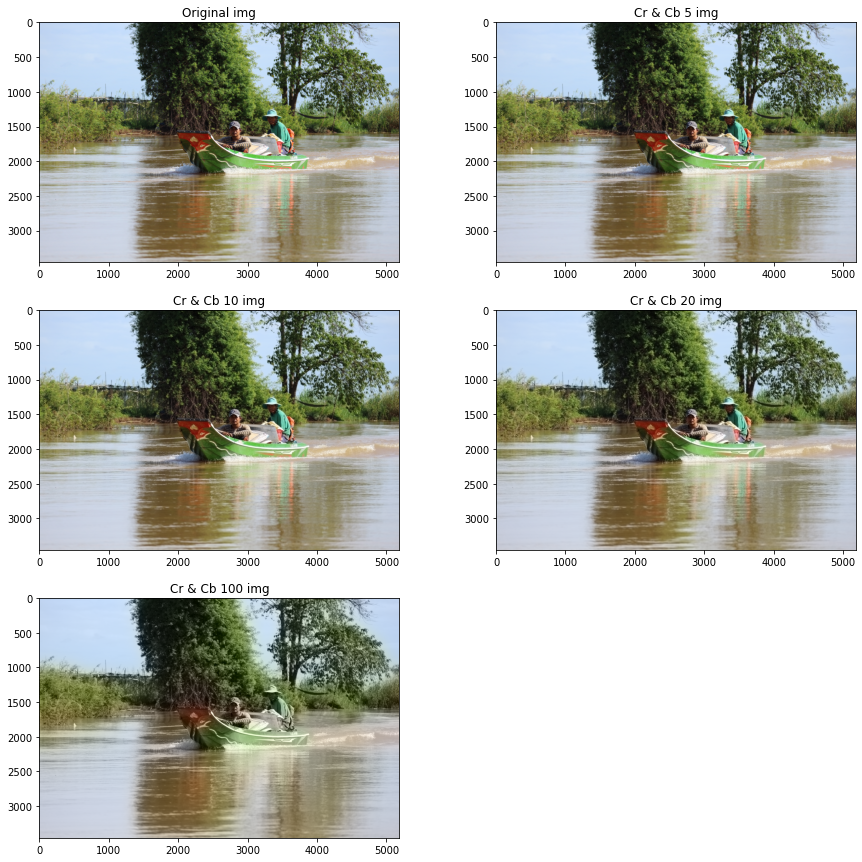

In [ ]:
compare_image([img, img_cb_cr_5, img_cb_cr_10, img_cb_cr_20, img_cb_cr_100], 
              ['Original img', 'Cr & Cb 5 img', 'Cr & Cb 10 img', 
              'Cr & Cb 20 img', 'Cr & Cb 100 img'])

#### Results analysis
<p align='justify'>
Applicando i filtri contemporaneamente sia alla componente Cb che alla componente Cr il risultato migliora rispetto alla singola applicazione. 
In particolare con $\sigma = 20$ l'immagine risulta essere comunque bella nel suo complesso e andando a zommare negli stessi punti dell'immagine analizzati in precedenza si nota come le alterazioni siano si presenti ma meno marcate. <br>
Ad esempio analizzando l'acqua in prua si nota che non sono più presenti schizzi verdi anche se si può notare un peggioramento nel colore complessivo, che però da meno impatto visivo rispetto al verde. Sull'alterazione del rosso in prua invece non si notano diversità.
</p>

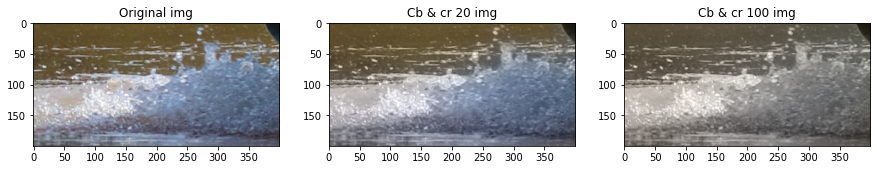

In [ ]:
# visualizzo l'acqua in prua per vedere la differenza tra originale, cb_cr_20, cb_cr_100
compare_image([img[2000:2200, 1800:2200], img_cb_cr_20[2000:2200, 1800:2200],
               img_cb_cr_100[2000:2200, 1800:2200]], 
              ['Original img', 'Cb & cr 20 img', 'Cb & cr 100 img'], 3, 1)

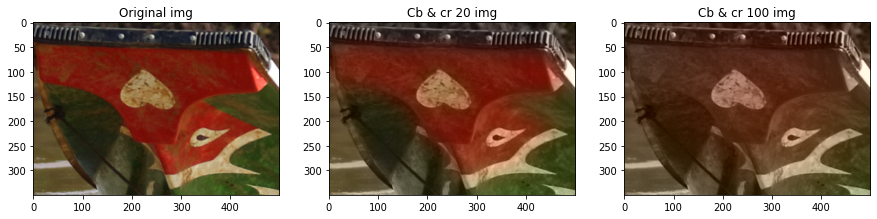

In [ ]:
# visualizzo la prua per vedere la differenza tra originale, cb & cr 
compare_image([img[1550:1900, 2000:2500], img_cb_cr_20[1550:1900, 2000:2500],
               img_cb_cr_100[1550:1900, 2000:2500]], 
              ['Original img', 'Cb & cr 20 img', 'Cb & cr 100 img'], 3, 1)


<p align='justify'>
Come nelle analisi precedenti si nota che con $\sigma = 20$ l'immagine rimane comunque bella da vedere, però per un salvataggio effettivo questo filtro potrebbe introdurre alterazioni non desiderate dall'utente e quindi sarebbe meglio applicare il filtro con $\sigma = 10$ che riduce l'immagine senza notevoli variazioni.
<p/>

In [ ]:
# Salvo l'immagine su disco nel caso si voglia vedere nel complesso
# PIL non supporta nativamente le immagini RGB con valori float, quindi li converto ad intero
Image.fromarray(float_image_to_int(img_cr_20)).save("test_cr_20.jpg", quality=100)

<p align='justify'>
Dall'altra parte a noi interessa in qualche modo ottimizzare anche lo spazio di archiviazione dell'immagine, si riportano di seguito i valori in MB necessari per salvare l'immagine su disco. <br>
<b>NB:</b> Tali valori sono ottenuti senza sfruttare la conversione jpg, lasciando quindi intatta la qualità dell'immagine al $100\%$
<p/>

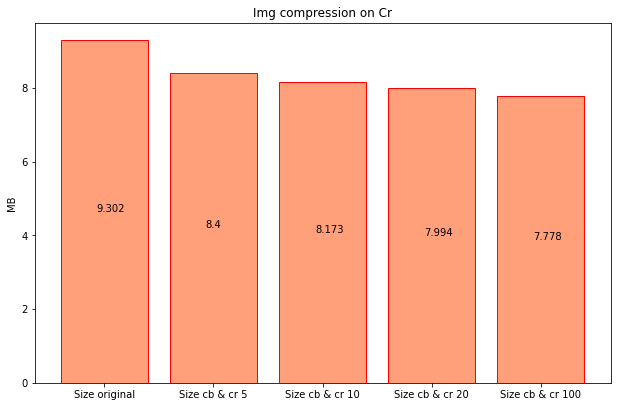

In [ ]:
# estraggo la stima della dimensione su disco delle immagini con e senza filtro

#size_img = get_img_mbytes(img)
size_img_cb_cr_5 = get_img_mbytes(img_cb_cr_5)
size_img_cb_cr_10 = get_img_mbytes(img_cb_cr_10)
size_img_cb_cr_20 = get_img_mbytes(img_cb_cr_20)
size_img_cb_cr_100 = get_img_mbytes(img_cb_cr_100)


# plotto i risultati in un grafico a barre
fig = plt.figure()
fig.set_size_inches(8,5)
ax = fig.add_axes([0,0,1,1])
langs = ['Size original', 'Size cb & cr 5', 'Size cb & cr 10', 
         'Size cb & cr 20', 'Size cb & cr 100']
ax.bar(langs, [size_img, size_img_cb_cr_5, size_img_cb_cr_10, 
               size_img_cb_cr_20, size_img_cb_cr_100], 
       color="lightsalmon",  edgecolor='red')
ax.set_title('Img compression on Cr')
ax.set_ylabel('MB')

# print value in bar
for pos, val in zip(range(0,5), [size_img, size_img_cb_cr_5, size_img_cb_cr_10, 
                            size_img_cb_cr_20, size_img_cb_cr_100]):
  plt.text(pos-.07, val/2, round(val,3))

plt.show()


<p align='justify'>
Dal grafico si nota, che applicando i due filtri contemporaneamente la compressione aumenti sensibilmente. Già con il filtro con $\sigma = 5$ infatti si ottiene una compressione di quasi $1$ MB!
<p>

In [ ]:
# elimino dalla memoria i filtri e le immagini filtrate che non utilizzerò più.
# non strettamente necessario, dipende dai GB di ram disponibili
del cb_5, cb_20, cb_100, cr_5, cr_20, cr_100, img_cb_10, img_cb_5, img_cb_20, img_cb_100, img_cr_10, img_cr_5, img_cr_20, img_cr_100

### Filter on Y
<p align='justify'>
Applico ora il filtro gaussiano sulla componente Y, questa è la componente a cui siamo più sensibili in quanto riporta la luminanza dell'immagine. In questo caso già con valori piccoli di $\sigma$ si nota subito la distorsione nell'immagine che risulta non più bella da vedere. Per questo motivo rivedo leggermente verso il basso i valori sigma utilizzati per il test.
<p/>

In [ ]:
# ripristino la colonna cb originale
img_ycbcr[:,:,1] = original_cb
# ripristino la colonna cr originale
img_ycbcr[:,:,2] = original_cr

In [ ]:
# applico il filtro gaussiano sulla componente y dell'immagine
y_2 = filters.gaussian(img_ycbcr[:,:,0], sigma=2)
y_5 = filters.gaussian(img_ycbcr[:,:,0], sigma=5)
y_10 = filters.gaussian(img_ycbcr[:,:,0], sigma=10)
y_20 = filters.gaussian(img_ycbcr[:,:,0], sigma=20)

<p align='justify'>
Per poter visualizzare correttamente le immagini è necessario riconvertire da ycbcr a rgb, nel farlo utilizzo le colonne appena create con i differenti filtri al posto della colonna y orinale. <br>
E' inoltre necessario riscalare i valori nel range $[0,1]$ in quanto durante la conversione la libreria skimage introduce dei valori leggermente fuori dal range (solo se si considerano tutte le n cifre decimali). Questo però genera dei warnings e/o errori durante la visualizzazione e il salvataggio del file in quanto sono valori non previsti nelle immagini rgb.
<p/>

In [ ]:
img_ycbcr[:,:,0] = y_2
# converto in rbg l'immagine con sigma = 2
img_y_2 = color.ycbcr2rgb(img_ycbcr)

img_ycbcr[:,:,0] = y_5
# converto in rbg l'immagine con sigma = 5
img_y_5 = color.ycbcr2rgb(img_ycbcr)

img_ycbcr[:,:,0] = y_10
# converto in rbg l'immagine con sigma = 10
img_y_10 = color.ycbcr2rgb(img_ycbcr)

img_ycbcr[:,:,0] = y_20
# converto in rbg l'immagine con sigma = 20
img_y_20 = color.ycbcr2rgb(img_ycbcr)

# riscalo i valori perchè in alcuni casi la eccedono il range [0,1] all'n-esima cifra dopo la virgola
img_y_2 = min_max_range_image(img_y_2)
img_y_5 = min_max_range_image(img_y_5)
img_y_10 = min_max_range_image(img_y_10)
img_y_20 = min_max_range_image(img_y_20)

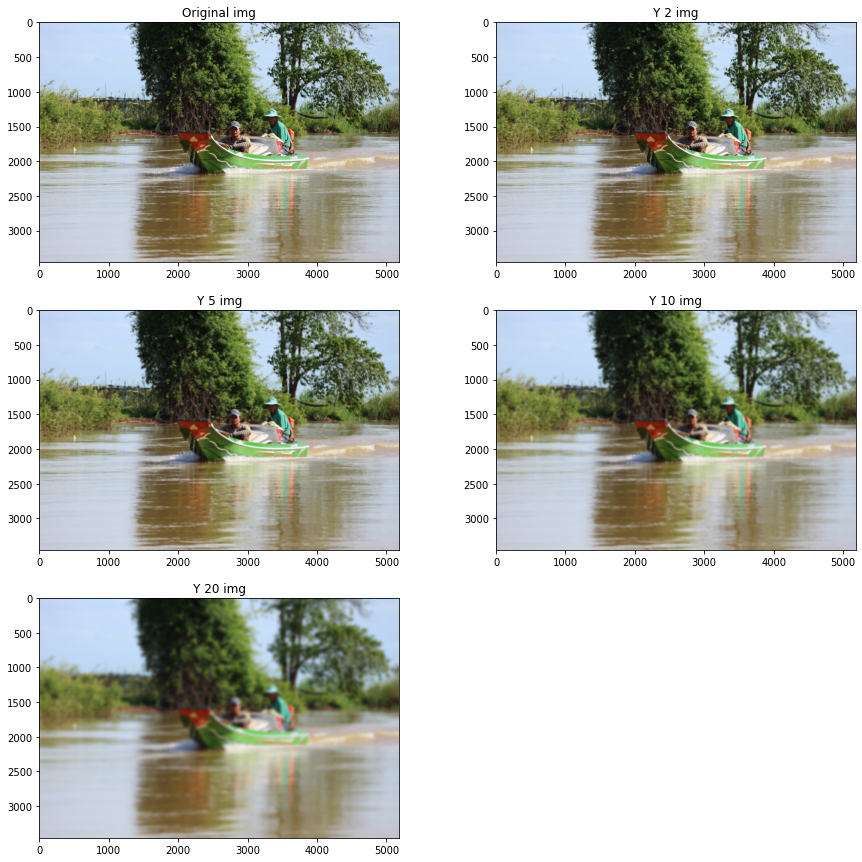

In [ ]:
compare_image([img, img_y_2, img_y_5, img_y_10, img_y_20], 
              ['Original img', 'Y 2 img', 'Y 5 img', 'Y 10 img', 'Y 20 img'])

#### Results analysis
<p align='justify'>
In questo caso l'immagine risulta poco bella da vedere anche con valori di sigma molto bassi, già con $\sigma = 2$ si iniziano a vedere le prime alterazioni (blur) dell'immagine. Si ricorda inoltre che in precedenza il valore minimo utilizzato per sigma era 5. Questo ci fa capire come noi siamo molto più sensibili a variazioni, anche minime, in questo canale. <br>
Si riporta di seguito un esempio di queste distorsioni per maggiore chiarezza.
</p>

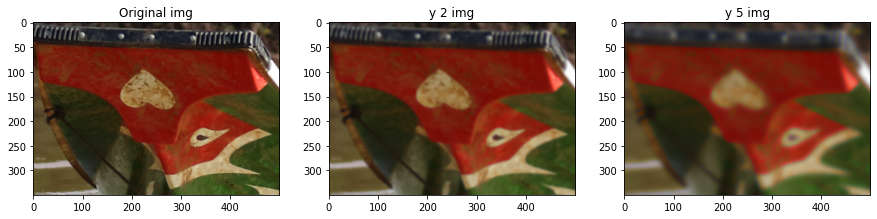

In [ ]:
# visualizzo la prua per vedere la differenza tra originale, y_2, y_5
compare_image([img[1550:1900, 2000:2500], img_y_2[1550:1900, 2000:2500],
               img_y_5[1550:1900, 2000:2500]], 
              ['Original img', 'y 2 img', 'y 5 img'], 3, 1)

<p align='justify'>
Da questo zoom si nota che anche l'immagine con $\sigma = 2$ introduce delle leggere alterazioni. Quindi anche il minimo cambiamento in questo canale non sia ideale in quanto introduce alterazioni non belle visivamente.
<p/>

In [ ]:
# Salvo l'immagine su disco nel caso si voglia vedere nel complesso
# PIL non supporta nativamente le immagini RGB con valori float, quindi li converto ad intero
Image.fromarray(float_image_to_int(img_y_2)).save("test_y_2.jpg", quality=100)

<p align='justify'>
Dall'altra parte a noi interessa in qualche modo ottimizzare anche lo spazio di archiviazione dell'immagine, si riportano di seguito i valori in MB necessari per salvare l'immagine su disco. <br>
<b>NB:</b> Tali valori sono ottenuti senza sfruttare la conversione jpg, lasciando quindi intatta la qualità dell'immagine al $100\%$
<p/>

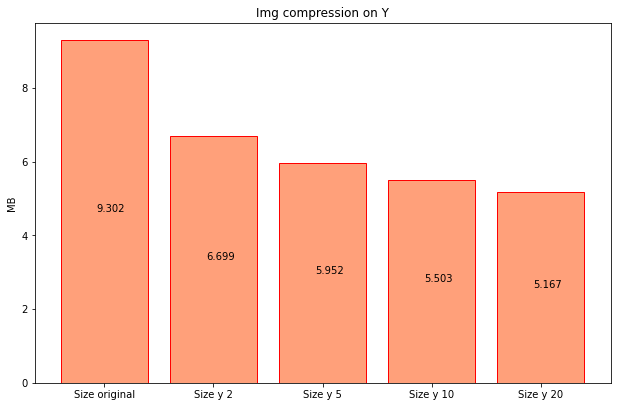

In [ ]:
# estraggo la stima della dimensione su disco delle immagini con e senza filtro

#size_img = get_img_mbytes(img)
size_img_y_2 = get_img_mbytes(img_y_2)
size_img_y_5 = get_img_mbytes(img_y_5)
size_img_y_10 = get_img_mbytes(img_y_10)
size_img_y_20 = get_img_mbytes(img_y_20)


# plotto i risultati in un grafico a barre
fig = plt.figure()
fig.set_size_inches(8,5)
ax = fig.add_axes([0,0,1,1])
langs = ['Size original',  'Size y 2', 'Size y 5', 'Size y 10', 'Size y 20']
ax.bar(langs, [size_img, size_img_y_2, size_img_y_5, size_img_y_10, size_img_y_20], 
       color="lightsalmon",  edgecolor='red')
ax.set_title('Img compression on Y')
ax.set_ylabel('MB')

# print value in bar
for pos, val in zip(range(0,5), [size_img, size_img_y_2, size_img_y_5, 
                                 size_img_y_10, size_img_y_20]):
  plt.text(pos-.07, val/2, round(val,3))

plt.show()

<p align='justify'>
Dal grafico si nota che leggere alterazioni in questo campo *riducano notevolmente la dimensione* effettiva dell'immagine. Tuttavia come già analizzato tale modifiche rovinano l'immagine a differenza di quanto accadeva con gli altri canali.
<p>

### Filter on Cb & Cr & Y
<p align='justify'>
Applico gli stessi passaggi appena effettuati su tutte le componenti dello spazio colore YCBCR.
<p/>

In [ ]:
# ripristino la colonna cb originale
img_ycbcr[:,:,0] = original_y
# ripristino la colonna cb originale
img_ycbcr[:,:,1] = original_cb
# ripristino la colonna cr originale
img_ycbcr[:,:,2] = original_cr

<p align='justify'>
Per poter visualizzare correttamente le immagini è necessario riconvertire da ycbcr a rgb, prima di farlo modifico le singole colonne delle componenti del canale. In particolare per i canali cb e cr utilizzo un filtro gaussiano abbastanza alto mentre per y utilizzo un filtro molto basso vicino ad 1.
<p/>

In [ ]:
# creo il nuovo filtro gaussiano con sigma = 0.9
img_ycbcr[:,:,0] = filters.gaussian(img_ycbcr[:,:,0], sigma=0.9)
img_ycbcr[:,:,1] = cb_10
img_ycbcr[:,:,2] = cr_10
# converto in rbg l'immagine con sigma = 5
img_all_change = color.ycbcr2rgb(img_ycbcr)

# riscalo i valori perchè in alcuni casi la eccedono il range [0,1] all'n-esima cifra dopo la virgola
img_all_change = min_max_range_image(img_all_change)

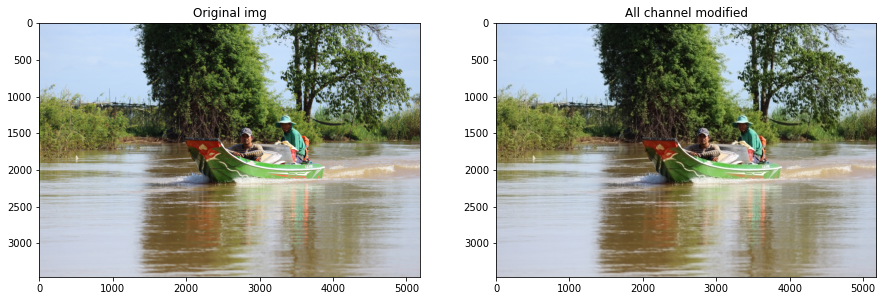

In [ ]:
compare_image([img, img_all_change],['Original img', 'All channel modified'])

#### Results analysis
<p align='justify'>
Unificando i filtri gaussiani applicati alle varie componenti, con il filtro su Y molto più basso, si riesce ad ottenere un risultato molto qualitativo che a colpo d'occhio rimane comunque bello da vedere e che anche zoomato riporta pochi artefatti. <br>
Di seguito si riportano i soliti pointi zoommati in precedenza per un confronto.
</p>

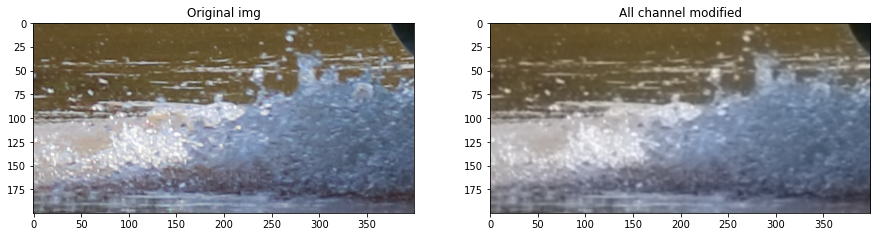

In [ ]:
# visualizzo l'acqua in prua per vedere la differenza tra originale e quella con tutte le modifiche
compare_image([img[2000:2200, 1800:2200], img_all_change[2000:2200, 1800:2200]], 
              ['Original img', 'All channel modified'])

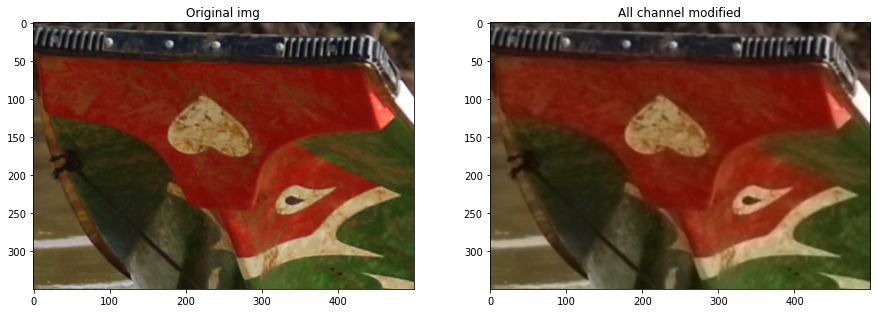

In [ ]:
# visualizzo la prua per vedere la differenza tra originale e all change
compare_image([img[1550:1900, 2000:2500], img_all_change[1550:1900, 2000:2500]], 
              ['Original img', 'All channel modified'])

<p align='justify'>
Dagli zoom si vede che c'è un leggero peggioramento però molto poco marcato e non visibile a colpo d'occhio se si guarda l'immagine nell'insieme.
Un artefatto un pò più marcato si può notare nell'intorno del cappello della persona seduta di dietro, anche in questo caso se zommato particolarmente.
<p/>

In [ ]:
# Salvo l'immagine su disco nel caso si voglia vedere nel complesso
# PIL non supporta nativamente le immagini RGB con valori float, quindi li converto ad intero
Image.fromarray(float_image_to_int(img_all_change)).save("test_all_change.jpg", quality=100)

<p align='justify'>
Dall'altra parte a noi interessa in qualche modo ottimizzare anche lo spazio di archiviazione dell'immagine, si riportano di seguito i valori in MB necessari per salvare l'immagine su disco. <br>
<b>NB:</b> Tali valori sono ottenuti senza sfruttare la conversione jpg, lasciando quindi intatta la qualità dell'immagine al $100\%$
<p/>

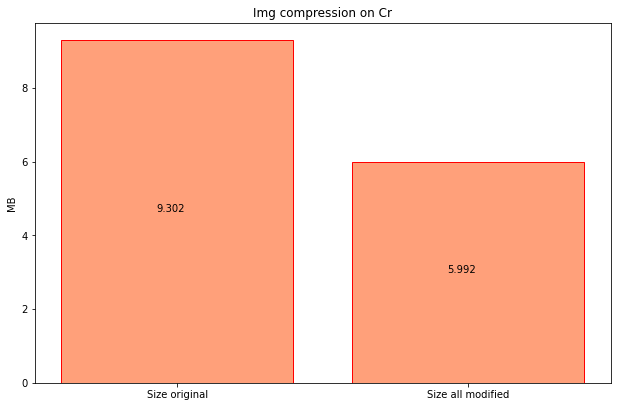

In [ ]:
# estraggo la stima della dimensione su disco delle immagini con e senza filtro

#size_img = get_img_mbytes(img)
size_img_all_change = get_img_mbytes(img_all_change)

# plotto i risultati in un grafico a barre
fig = plt.figure()
fig.set_size_inches(8,5)
ax = fig.add_axes([0,0,1,1])
langs = ['Size original', 'Size all modified']
ax.bar(langs, [size_img, size_img_all_change], 
       color="lightsalmon",  edgecolor='red')
ax.set_title('Img compression on Cr')
ax.set_ylabel('MB')

# print value in bar
for pos, val in zip(range(0,2), [size_img, size_img_all_change]):
  plt.text(pos-.07, val/2, round(val,3))

plt.show()

<p align='justify'>
Dal grafico si nota che unendo i filtri su tutti i canali la diminuzione in termini di MB è molto maggiore rispetto a tutte quelle ottenute finora con perdite di qualità comunque minime. Si ritiene questa la soluzione migliore (forse con un sigma ancora minore su y, in base al dispositivo di salvataggio e utilizzo finale dell'immagine).
</p>

In [5]:
%%shell
jupyter nbconvert --to html '/content/gdrive/MyDrive/Colab Notebooks/DigitalSignal/Assignment/Assignment2/DSIM_Assignment2.ipynb'

[NbConvertApp] Converting notebook /content/gdrive/MyDrive/Colab Notebooks/DigitalSignal/Assignment/Assignment2/DSIM_Assignment2.ipynb to html
[NbConvertApp] Writing 8529642 bytes to /content/gdrive/MyDrive/Colab Notebooks/DigitalSignal/Assignment/Assignment2/DSIM_Assignment2.html
